# NYSE Index Time Series Analysis

<img src="https://www.marketplace.org/wp-content/uploads/2019/09/stockmarket.jpg?fit=2880%2C1621" width="500"/>

1. Problem definition

2. Acquire data

3. Data cleaning 

4. Time series Analysis
- Check for stationarity
- Check for autocorrelation
- Trend decomposition 
- Forecast future values

6. Build Model and explain the performance

7. Submit the results.

## 1. Problem definition

>Stock Analysis for Apple stock

>How to classify similar stocks based on time series

Q. I would like to group similar stock based on the trend
- basic research how to compare two trends
- how to analyze a trend
Q. two stock groups with polar growth rate
Q. Predict the stock price for tomorrow
Q. $10 and below stocks vs the return of $100 and above stocks
Q. find good day and bad day for the industry
Q. Bankrupt prediction


+ add sectors (gihong)
+ company year founded, company name (kyle)

correlation between two stocks

first copute percentage changes of both series
apple_change = df['apple_price'].pct_change()
tesla_change = df['tesla_price'].pct_change()

plt.scatter(apple_change, tesla_change)
correlation = apple_change corr(tesla change)

In [1]:
# Data manipulation
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Data Visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Machine Learning
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.datasets import make_classification
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import chi2
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score

import math
import os
import pickle

## 2. Acquire Data

In [3]:
df = pd.read_csv("prices-split-adjusted.csv")
print(df.shape)
print(df.columns)

(851264, 7)
Index(['date', 'symbol', 'open', 'close', 'low', 'high', 'volume'], dtype='object')


In [33]:
df.head()

,date,symbol,open,close,low,high,volume
0,2016-01-05,WLTW,123.430000,125.839996,122.309998,126.250000,2163600.0
1,2016-01-06,WLTW,125.239998,119.980003,119.940002,125.540001,2386400.0
2,2016-01-07,WLTW,116.379997,114.949997,114.930000,119.739998,2489500.0
3,2016-01-08,WLTW,115.480003,116.620003,113.500000,117.440002,2006300.0
4,2016-01-11,WLTW,117.010002,114.970001,114.089996,117.330002,1408600.0


## 3. Data cleaning

Before answer the main questions, "How to classify similar stocks based on time series analysis". we would like to choose APPL stock and do analysis on it.

In [4]:
df_apple = df[df['symbol'] == 'AAPL']

In [5]:
df_apple.shape

(1762, 7)

In [7]:
print(df_apple['date'].min())
print(df_apple['date'].max())

2010-01-04
2016-12-30


In [12]:
df_apple['date'] = pd.to_datetime(df['date'], format = '%Y-%m')
df_apple.head()

/var/folders/ph/yfqxnlss1ds28x8n8wzmqfg00000gn/T/ipykernel_4187/2290568549.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_apple['date'] = pd.to_datetime(df['date'], format = '%Y-%m')


,date,symbol,open,close,low,high,volume
254,2010-01-04,AAPL,30.490000,30.572857,30.340000,30.642857,123432400.0
721,2010-01-05,AAPL,30.657143,30.625713,30.464285,30.798571,150476200.0
1189,2010-01-06,AAPL,30.625713,30.138571,30.107143,30.747143,138040000.0
1657,2010-01-07,AAPL,30.250000,30.082857,29.864286,30.285715,119282800.0
2125,2010-01-08,AAPL,30.042856,30.282858,29.865715,30.285715,111902700.0


In [15]:
df_apple.index = df_apple['date']
del df_apple['date']
df_apple.head()

,symbol,open,close,low,high,volume
date,,,,,,
2010-01-04,AAPL,30.490000,30.572857,30.340000,30.642857,123432400.0
2010-01-05,AAPL,30.657143,30.625713,30.464285,30.798571,150476200.0
2010-01-06,AAPL,30.625713,30.138571,30.107143,30.747143,138040000.0
2010-01-07,AAPL,30.250000,30.082857,29.864286,30.285715,119282800.0
2010-01-08,AAPL,30.042856,30.282858,29.865715,30.285715,111902700.0


## 4. Time series analysis

#### Check for the stationarity

**What is Stationarity and why is it important?**

Stationarity is a way to measure if the data has structural patterns like seasonal trends. You need to check for both of these in time series data because they’re assumptions that are made by many widely used methods in time series analysis. For example, the autoregressive integrated moving average (ARIMA) method for forecasting time series assumes stationarity. Simply put, stationarity means that the manner in which time series data changes is constant. A stationary time series will not have any trends or seasonal patterns. Specifically, stationarity is assumed for a wide variety of time series forecasting methods including autoregressive moving average (ARMA), ARIMA and Seasonal ARIMA (SARIMA).

<AxesSubplot:xlabel='date', ylabel='close'>

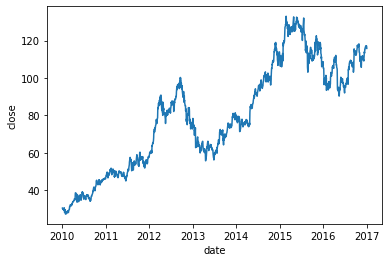

In [18]:
sns.lineplot(x=df_apple.index, y= df_apple['close'])

**How to check for stationarity in our data**

We will use the Dickey Fuller test. This test will generate critical values and a p-value, which will allow us to accept or reject the null hypothesis that there is no stationarity. If we reject the null hypothesis, that means we accept the alternative, which states that there is stationarity.

Let's test for stationarity in our APPL data. To start, let's calculate a six-month rolling mean:

In [20]:
rolling_mean = df_apple['close'].rolling(180).mean()
rolling_std = df_apple['close'].rolling(180).std()

date
2010-01-04           NaN
2010-01-05           NaN
2010-01-06           NaN
2010-01-07           NaN
2010-01-08           NaN
                 ...    
2016-12-23    105.814333
2016-12-27    105.852222
2016-12-28    105.878444
2016-12-29    105.904167
2016-12-30    105.937333
Name: close, Length: 1762, dtype: float64

Let's overlay our time sereis with six-month rolling mean and six month rolling standard deviation.

<AxesSubplot:xlabel='date', ylabel='close'>

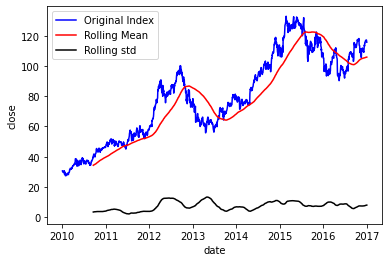

In [30]:
sns.lineplot(x=df_apple.index, y= df_apple['close'], color = 'blue', label = 'Original Index')
sns.lineplot(x=df_apple.index, y= rolling_mean, color = 'red', label = 'Rolling Mean')
sns.lineplot(x=df_apple.index, y= rolling_std, color = 'black', label = 'Rolling std')

Let's import augmented Dickey-Fuller test

In [31]:
from statsmodels.tsa.stattools import adfuller

In [32]:
# pass the data and specify the autolag parameter as "AIC"
adft = adfuller(df_apple['close'], autolag= 'AIC')

In [33]:
output_df = pd.DataFrame({"Values":[adft[0],adft[1],adft[2],adft[3], adft[4]['1%'], adft[4]['5%'], adft[4]['10%']]  , "Metric":["Test Statistics","p-value","No. of lags used","Number of observations used", 
                                                        "critical value (1%)", "critical value (5%)", "critical value (10%)"]})
print(output_df)

        Values                       Metric
0    -1.324458              Test Statistics
1     0.617910                      p-value
2     0.000000             No. of lags used
3  1761.000000  Number of observations used
4    -3.434069          critical value (1%)
5    -2.863183          critical value (5%)
6    -2.567645         critical value (10%)


With the above data, we can conclude that the dasta is not stationary since p > 0.05 and we accept the null hypothesis("it is not stationary")

In other words, fromm the graph we can clearly see the increasing trend in the APPL index

#### Check for the stationarity